# Kaggle Titanic Survior Predictions

## Problem: 
Given a training set of samples listing passengers who survived or did not survive the Titanic disaster, create a model to determine based on a given test dataset not containing the survival information, if these passengers in the test dataset survived or not.

## Background
On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

### Import modules

Note: This notebook uses features introduced in Python 3.6 and sklearn 0.20. 

First we'll need a few imports:

In [53]:
import warnings
warnings.filterwarnings("ignore")
# Obviously
import pandas as pd
import numpy as np

# Some sklearn tools for preprocessing. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# In terms of metric we'll need balanced accuracy score and classification report
# More on that later...
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

# Our algorithms, from the easiest to the hardest to intepret.
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb

# import our visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib as mpl
#visualization settings
sns.set(style='white', context='notebook', palette='deep')
pylab.rcParams['figure.figsize'] = 12,8
mpl.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Data Dictionary

The data is based on a dataset available [here](https://www.kaggle.com/startupsci/titanic-data-science-solutions/data). 

1. **Age** :
    1. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
​
1. **Sibsp** : 
    1. Number of siblings / spouses aboard the Titanic
    2. The dataset defines family relations in this way...
​
        a. Sibling = brother, sister, stepbrother, stepsister
​
        b. Spouse = husband, wife (mistresses and fiancés were ignored)
​
1. **Parch**:
    1. Number of parents / children aboard the Titanic 
    2. The dataset defines family relations in this way...
​
        a. Parent = mother, father
​
        b. Child = daughter, son, stepdaughter, stepson
​
        c. Some children travelled only with a nanny, therefore parch=0 for them.
​
1. **Pclass** : 
    *  A proxy for socio-economic status (SES)
        * 1st = Upper
        * 2nd = Middle
        * 3rd = Lower
1. **Embarked** : 
     * nominal datatype 
1. **Name**: 
    * nominal datatype . It could be used in feature engineering to derive the gender from title
1. **Sex**: 
   * nominal datatype 
1. **Ticket**:
    * that have no impact on the outcome variable. Thus, they will be excluded from analysis
1. **Cabin**: 
    * is a nominal datatype that can be used in feature engineering
1.  **Fare**:
    * Indicating the fare
1. **PassengerID**:
    * have no impact on the outcome variable. Thus, it will be excluded from analysis
1. **Survival**:
    * **[dependent variable](http://www.dailysmarty.com/posts/difference-between-independent-and-dependent-variables-in-machine-learning)** , 0 or 1
    
### Which features are categorical?

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

Categorical: Survived, Sex, and Embarked. 
Ordinal: Pclass.


### Which features are numerical? 

These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

Continous: Age, Fare. 
Discrete: SibSp, Parch.

### Which features are mixed data types?

Numerical, alphanumeric data within same feature. These are candidates for correcting goal.

Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

### Which features may contain errors or typos?

This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require correcting.

Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

### The Dataset

In [2]:
#import data
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

combine = [train_df, test_df]
#dft = pd.concat(combined)
#view head of data
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [4]:
#summary stats of numerical data
train_df.describe()
#38% survival rate

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#summary of categoricals
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Skoog, Miss. Margit Elizabeth",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


In [6]:
# get null values
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Assumtions based on data analysis
We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

### Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

### Completing.

We may want to complete Age feature as it is definitely correlated to survival.
We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

### Correcting.

Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
PassengerId may be dropped from training dataset as it does not contribute to survival.
Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

### Creating.

We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
We may want to engineer the Name feature to extract Title as a new feature.
We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
We may also want to create a Fare range feature if it helps our analysis.

### Classifying.

We may also add to our assumptions based on the problem description noted earlier.

Women (Sex=female) were more likely to have survived.
Children (Age<?) were more likely to have survived.
The upper-class passengers (Pclass=1) were more likely to have survived.

### Analyze by pivoting features
To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

Pclass We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
Sex We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
SibSp and Parch These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1).

In [7]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

Pclass  Survived     
              mean  sum
0      1  0.629630  136
1      2  0.472826   87
2      3  0.242363  119

In [8]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

Sex  Survived     
               mean  sum
0  female  0.742038  233
1    male  0.188908  109

In [9]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

SibSp  Survived     
             mean  sum
1     1  0.535885  112
2     2  0.464286   13
0     0  0.345395  210
3     3  0.250000    4
4     4  0.166667    3
5     5  0.000000    0
6     8  0.000000    0

## Analyze by visualizing data¶
Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features
Let us start by understanding correlations between numerical features and our solution goal (Survived).

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

Note that x-axis in historgram visualizations represents the count of samples or passengers.

### Observations.

Infants (Age <=4) had high survival rate.
Oldest passengers (Age = 80) survived.
Large number of 15-25 year olds did not survive.
Most passengers are in 15-35 age range.

### Decisions.

This simple analysis confirms our assumptions as decisions for subsequent workflow stages.

We should consider Age (our assumption classifying #2) in our model training.

Complete the Age feature for null values (completing #1).

We should band age groups (creating #3).

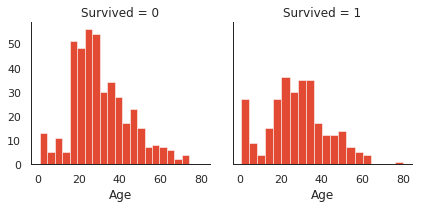

In [10]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## Correlating numerical and ordinal features
We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.

### Observations.

Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
Pclass varies in terms of Age distribution of passengers.
### Decisions.

Consider Pclass for model training.

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


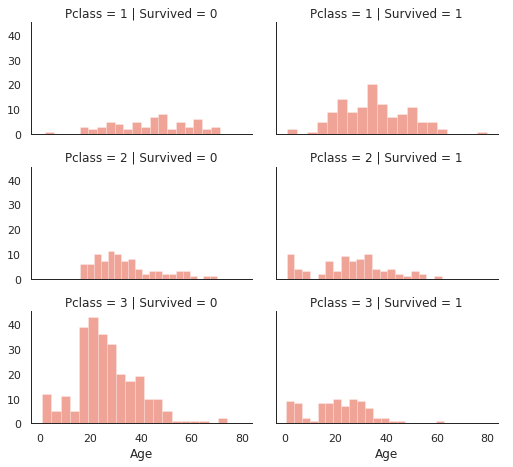

In [11]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## Correlating categorical features
Now we can correlate categorical features with our solution goal.

### Observations.

Female passengers had much better survival rate than males. Confirms classifying (#1).
Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

### Decisions.

Add Sex feature to model training.
Complete and add Embarked feature to model training.

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


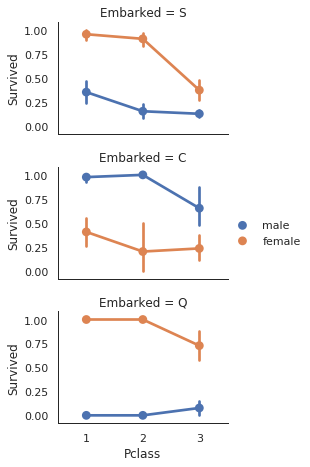

In [12]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

## Correlating categorical and numerical features
We may also want to correlate categorical features (with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric).

### Observations.

Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

### Decisions.

Consider banding Fare feature.

/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/home/michael/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


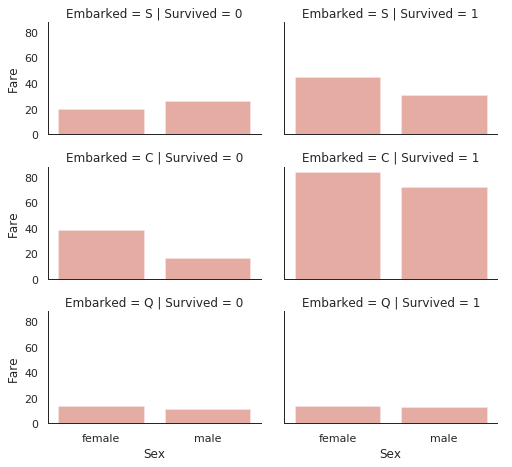

In [13]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

### Other Correlations

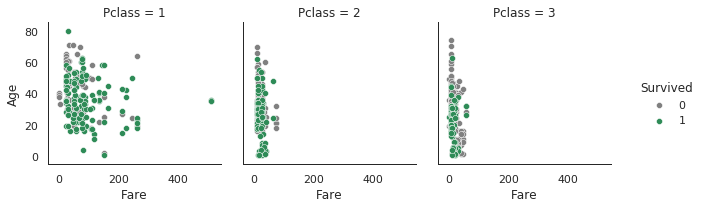

In [14]:
#explore relationship between class and survival
g = sns.FacetGrid(train_df, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"seagreen", 0:"gray"})
g = g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

### Pclass and Age

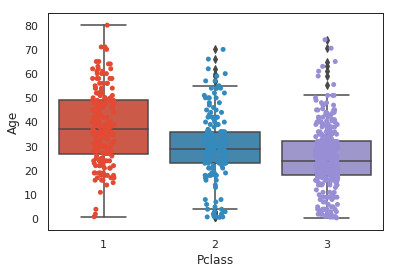

In [15]:
ax = sns.boxplot(x="Pclass", y="Age", data=train_df)
ax = sns.stripplot(x="Pclass", y="Age", data=train_df, jitter=True, edgecolor="gray")
plt.show()

## Wrangle data
We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating, and completing goals.

### Correcting by dropping features
This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin (correcting #2) and Ticket (correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [16]:
print("Before", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

"After", train_df.shape, test_df.shape, combine[0].shape, combine[1].shape

Before (891, 12) (418, 11) (891, 12) (418, 11)


('After', (891, 10), (418, 9), (891, 10), (418, 9))

## Creating new feature extracting from existing
We want to analyze if Name feature can be engineered to extract titles and test correlation between titles and survival, before dropping Name and PassengerId features.

In the following code we extract Title feature using regular expressions. The RegEx pattern (\w+\.) matches the first word which ends with a dot character within Name feature. The expand=False flag returns a DataFrame.

### Observations.

When we plot Title, Age, and Survived, we note the following observations.

Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
Survival among Title Age bands varies slightly.
Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

### Decision.

We decide to retain the new Title feature for model training.

In [17]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [18]:
# rename titles
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

Title  Survived     
               mean  sum
3     Mrs  0.793651  100
1    Miss  0.702703  130
0  Master  0.575000   23
4    Rare  0.347826    8
2      Mr  0.156673   81

In [19]:
#convert sex to binary
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr


In [20]:
#impute age values based on class and sex
guess_ages = np.zeros((2,3))
guess_ages

#get the median age by group
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

#drop unneeded columns
# train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
# test_df = test_df.drop(['Name'], axis=1))
# combine = [train_df, test_df]        
train_df.head()



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,8.0500,S,Mr


In [21]:
#age bands
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

AgeBand  Survived     
                      mean  sum
0  (-0.08, 16.0]  0.550000   55
3   (48.0, 64.0]  0.434783   30
2   (32.0, 48.0]  0.412037   89
1   (16.0, 32.0]  0.337374  167
4   (64.0, 80.0]  0.090909    1

In [22]:
#create ordinal bands for age
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    dataset = dataset.drop(['Age'], axis = 1)
    
#drop unused ageband in train df    
train_df = train_df.drop(['AgeBand'], axis=1)

combine = [train_df, test_df]   
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,8.0500,S,Mr


In [23]:
#compute total family size feature and add one for self
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

FamilySize  Survived     
                  mean  sum
3          4  0.724138   21
2          3  0.578431   59
1          2  0.552795   89
6          7  0.333333    4
0          1  0.303538  163
4          5  0.200000    3
5          6  0.136364    3
7          8  0.000000    0
8         11  0.000000    0

In [24]:
#compute is alone feature
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

IsAlone  Survived     
               mean  sum
0       0  0.505650  179
1       1  0.303538  163

In [25]:
#create feature for age class
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


In [26]:
#impute embark port for nas
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [27]:
#fill na with most common value
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

Embarked  Survived     
                mean  sum
0        C  0.553571   93
1        Q  0.389610   30
2        S  0.339009  219

In [28]:
#impute fares
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,892,3,"Kelly, Mr. James",0,2,0,0,7.8292,Q,Mr,1,1,6
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,2,1,0,7.0000,S,Mrs,2,0,6
2,894,2,"Myles, Mr. Thomas Francis",0,3,0,0,9.6875,Q,Mr,1,1,6
3,895,3,"Wirz, Mr. Albert",0,1,0,0,8.6625,S,Mr,1,1,3
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1,1,12.2875,S,Mrs,3,0,3


In [29]:
#fare bins
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).agg({"Survived": [np.mean, np.sum]}).sort_values(by = ('Survived', 'mean'), ascending=False)

FareBand  Survived     
                        mean  sum
3  (31.0, 512.329]  0.581081  129
2   (14.454, 31.0]  0.454955  101
1   (7.91, 14.454]  0.303571   68
0   (-0.001, 7.91]  0.197309   44

In [30]:
#create ordinal fares
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

#drop fareband in train df
train_df = train_df.drop(['FareBand'], axis=1)

combine = [train_df, test_df]
    
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,Age*Class
0,1,0,3,"Braund, Mr. Owen Harris",0,1,1,0,0,S,Mr,2,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2,1,0,3,C,Mrs,2,0,2
2,3,1,3,"Heikkinen, Miss. Laina",1,1,0,0,1,S,Miss,1,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2,1,0,3,S,Mrs,2,0,2
4,5,0,3,"Allen, Mr. William Henry",0,2,0,0,1,S,Mr,1,1,6
5,6,0,3,"Moran, Mr. James",0,1,0,0,1,Q,Mr,1,1,3
6,7,0,1,"McCarthy, Mr. Timothy J",0,3,0,0,3,S,Mr,1,1,3
7,8,0,3,"Palsson, Master. Gosta Leonard",0,0,3,1,2,S,Master,5,0,0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,1,0,2,1,S,Mrs,3,0,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,0,1,0,2,C,Mrs,2,0,0


In [31]:
#drop unused columns
test_df = test_df.drop(['Parch', 'Name', 'SibSp', 'FamilySize'], axis=1)

train_df = train_df.drop(['PassengerId', 'Parch', 'Name', 'SibSp', 'FamilySize'], axis=1)

combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,S,Mr,0,3
1,1,1,1,2,3,C,Mrs,0,2
2,1,3,1,1,1,S,Miss,1,3
3,1,1,1,2,3,S,Mrs,0,2
4,0,3,0,2,1,S,Mr,1,6


In [32]:
#on the train df, separate to x and y variables
y_train = train_df['Survived']
x_train = train_df.drop(['Survived'], axis = 1)

#split test set so we can one hot encode
test_passid = test_df['PassengerId']
x_test = test_df.drop(['PassengerId'], axis=1)

In [33]:
print(x_train.head())

print('-'*40)

print(x_test.head())

   Pclass  Sex  Age  Fare Embarked Title  IsAlone  Age*Class
0       3    0    1     0        S    Mr        0          3
1       1    1    2     3        C   Mrs        0          2
2       3    1    1     1        S  Miss        1          3
3       1    1    2     3        S   Mrs        0          2
4       3    0    2     1        S    Mr        1          6
----------------------------------------
   Pclass  Sex  Age  Fare Embarked Title  IsAlone  Age*Class
0       3    0    2     0        Q    Mr        1          6
1       3    1    2     0        S   Mrs        0          6
2       2    0    3     1        Q    Mr        1          6
3       3    0    1     1        S    Mr        1          3
4       3    1    1     1        S   Mrs        0          3


In [34]:
# create numerical and clissification lists
num_features = ["Pclass", "Sex", "Age", "Fare","IsAlone","Age*Class"]

cat_features = ["Embarked", "Title"]

In [35]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

Now we can create processed versions of X_train and X_test, ready to be used by our algorithms. To do so we will start by fitting the processor on X_train:

In [36]:
preprocessor.fit(x_train)

preprocessor.transform(x_train)

array([[3., 0., 1., ..., 1., 0., 0.],
       [1., 1., 2., ..., 0., 1., 0.],
       [3., 1., 1., ..., 0., 0., 0.],
       ...,
       [3., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [3., 0., 1., ..., 1., 0., 0.]])

When we call transform, the preprocessor returns a numpy array, which is great for Machine Learning algorithms to process ... but not so great for us humans to interpret. So we will wrap it up back to DataFrame with nice column names. To do so we will need to give nice names to the dummy feature generated by the one hot encoder. The code below extracts the list of categories, creates nice names for the dummy feature and create a new list `all_features` with good names for our columns:

In [37]:
# Get the list of categories generated by the process
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

# Create nice names for our one hot encoded features
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

# Create a new list with all names of features
all_features = num_features + new_ohe_features

Great, now we can create our preprocessed DataFrames with good column names:

In [38]:
x_train = pd.DataFrame(preprocessor.transform(x_train), columns=all_features)
x_test = pd.DataFrame(preprocessor.transform(x_test), columns=all_features)

In [39]:
x_train.head()

,Pclass,Sex,Age,Fare,IsAlone,Age*Class,Embarked__C,Embarked__Q,Embarked__S,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Rare
0,3.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,2.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.0,1.0,1.0,1.0,1.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,3.0,0.0,2.0,1.0,1.0,6.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Looks good!

# Select Model(s)

Define `class_weight` to be balanced in order to take into account the imbalance in our dataset. 

In [81]:
# Logistic Regression

lr_model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)
#cross validate
gs = GridSearchCV(lr_model, {"C": [1., 1.3, 1.5]}
                  , n_jobs=-1
                  , cv = StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)


# reassign our best model
lr_model = gs.best_estimator_
lr_y_pred = lr_model.predict(x_test)


#get params
print(gs.best_params_)
lracc = gs.best_score_
print('Accuracy Score:')
print(lracc)

{'C': 1.5}
Accuracy Score:
0.7769054693256707


In [72]:
# Support Vector Machines

svc_model = SVC(class_weight="balanced", random_state=42)
#cross validate
gs = GridSearchCV(svc_model, {"C": [1., 1.3, 1.5]}
                  , n_jobs=-1
                  , cv = StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)

# reassign our best model
svc_model = gs.best_estimator_
svc_y_pred = svc_model.predict(x_test)


#get params
print(gs.best_params_)
svcacc = gs.best_score_
print('Accuracy Score:')
print(svcacc)

{'C': 1.5}
Accuracy Score:
0.7757166139392196


In [73]:
# KNN
knn_model = KNeighborsClassifier()
#cross validate
gs = GridSearchCV(knn_model, {"n_neighbors": [3,5,11,19], 
                            'weights':['uniform', 'distance'],
                             'metric':['euclidean', 'manhattan']}
                  , n_jobs=-1
                  , cv = StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")

gs.fit(x_train, y_train)

# reassign our best model
knn_model = gs.best_estimator_
knn_y_pred = knn_model.predict(x_test)

#get params
print(gs.best_params_)
knnacc = gs.best_score_
print('Accuracy Score:')
print(knnacc)

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Accuracy Score:
0.777993480970185


In [97]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight="balanced", random_state=42)
#cross validate
gs = GridSearchCV(dt_model, {'min_samples_split' : [2,5,10]
                             ,'max_depth': range(1,20,2)}
                  , n_jobs=-1
                  , cv=StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)

# reassign our best model
dt_model = gs.best_estimator_
dt_y_pred = dt_model.predict(x_test)


#get params
print(gs.best_params_)
dtcacc = gs.best_score_
print('Accuracy Score:')
print(dtcacc)


{'max_depth': 7, 'min_samples_split': 10}
Accuracy Score:
0.8017990352549074


In [106]:
# Random Forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 75, stop = 160, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the search grid
search_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_model = RandomForestClassifier(class_weight="balanced", random_state=42)
#cross validate
gs = GridSearchCV(rf_model, search_grid
                  , n_jobs=-1
                  , cv=StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)

# reassign our best model
rf_model = gs.best_estimator_
rf_y_pred = rf_model.predict(x_test)


#get params
print(gs.best_params_)
rfcacc = gs.best_score_
print('Accuracy Score:')
print(rfcacc)

{'bootstrap': True, 'max_depth': 16, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 96}
Accuracy Score:
0.809409571543345


In [116]:
# LightGBM -- Boosting model

# number of leaves
num_leaves=[[int(x)] for x in np.linspace(10, 30, num = 6)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Number of estimators
n_estimators=[int(x) for x in np.linspace(start = 75, stop = 160, num = 5)]


# Create the search grid
search_grid = {'num_leaves': num_leaves,
               'n_estimators': n_estimators,
               'max_depth': max_depth}

lgb_model = LGBMClassifier(class_weight="balanced", random_state=42)

#grid search and cross validate
gs = GridSearchCV(lgb_model
                  , search_grid
                  , n_jobs=-1
                  , cv=StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)

# reassign our best model
lgb_model = gs.best_estimator_
lgb_y_pred = lgb_model.predict(x_test)


#get params
print(gs.best_params_)
lgbcacc = gs.best_score_
print('Accuracy Score:')
print(lgbcacc)

{'max_depth': 8, 'n_estimators': 75, 'num_leaves': [18]}
Accuracy Score:
0.8244091702031633


In [117]:
# xgboost -- Boosting model

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 20, num = 5)]
# Number of estimators
n_estimators=[int(x) for x in np.linspace(start = 75, stop = 200, num = 2)]
scale_pos_weight=[1.5]

# Create the search grid
search_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              'scale_pos_weight': scale_pos_weight
              }

xgb_model = xgb.XGBClassifier(class_weight="balanced", 
                              random_state=42)

#grid search and cross validate
gs = GridSearchCV(xgb_model, search_grid
                  , n_jobs=-1
                  , cv=StratifiedKFold(n_splits = 5).split(x_train, y_train)
                  , scoring="balanced_accuracy")
gs.fit(x_train, y_train)

# reassign our best model
xgb_model = gs.best_estimator_
xgb_y_pred = xgb_model.predict(x_test)


#get params
print(gs.best_params_)
xgbcacc = gs.best_score_
print('Accuracy Score:')
print(xgbcacc)

{'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1.5}
Accuracy Score:
0.8001146398268087


In [118]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": lgb_y_pred
    })
submission.to_csv('data/submission.csv', index=False)

In [119]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": xgb_y_pred
    })
submission.to_csv('data/submissionxgb.csv', index=False)